### read me
so far this code will:  
1. extract video frames from the given video (you can adjust the number of frames it creates in code cell 2)  
   FYI: a new dir will be created called vidname_image_frames which will store all of the extracted image frames from the vid
3. use EAST to extract bounding boxes over one given frame (**it only processes one frame rn**)  
   --  a new dir. will be created called out_framename, which will contain the crops of the individual words determined by the bounding boxes and also the original image with the green bounding boxes drawn over it   
   -- I used some code I found online for this and tweaked it a bit  
   -- If you want to get different bounding boxes, you can adjust this line in cell 3: (newW, newH) = (672, 672) to different numbers and it'll give you different bounding boxes. tbh I don't really know what this means or how to logically choose these numbers: they just need to be multiples of 32 or it'll throw an error. These values gave me the best results for this frame lol

**You need to update the following paths to test on your own machine:**
1. cell 2: vidpath (the path to the video you want to process: i'm using testseq.mp4 from the google drive)  
2. cell 3: video_frames_dir (the path to the dir. created in step 1, which holds the extracted frames)  
3. cell 3: frame_path (the path to the specific frame that you want to process)

**You also need to save the pre-trained model weights file to your root dir/wherever ur running this notebook**  
frozen_east_text_detection.pb

in the end your rootdir will contain:  

thisNotebook.ipynb  
frozen_east_text_detection.pb  
testvid.mp4  
testseq_image_frames  
----> frames 1-n  
out_framename   
----> crops of individual words  
----> original frame with bounding boxes drawn on top 

In [86]:
from PIL import Image
import os, sys
import cv2
import numpy as np
from imutils.object_detection import non_max_suppression

### Extract Video Frames from Video

In [2]:
def files(vidpath):
    base_name = os.path.basename(vidpath)
    vidname, _ = os.path.splitext(base_name)  # Split the base name to get the name without the extension
    
    try: # Remove image frames path if it already exists
        os.remove(f"{vidname}_image_frames")
    except OSError:
        pass
    if not os.path.exists(f"{vidname}_image_frames"): # create the directory if it does not already exist
        os.makedirs(f"{vidname}_image_frames")

    src_vid = cv2.VideoCapture(vidpath) # open the video file
    return(src_vid)
    
def process(src_vid):
    base_name = os.path.basename(vidpath)
    vidname, _ = os.path.splitext(base_name)  # Split the base name to get the name without the extension
    
    index = 0
    while src_vid.isOpened():
        ret, frame = src_vid.read() 
        if not ret: # break at the end of the video (ret returns True if frame is succesfully read)
            break
        name = f'./{vidname}_image_frames/frame{str(index)}.png'

        if index % 50 == 0: # every 50th frame will be saved: can adjust this number to capture more or less frames
            print('Extracting frame...' + name)
            cv2.imwrite(name, frame)
        index = index + 1
        
    src_vid.release()
    cv2.destroyAllWindows()

if __name__ == '__main__':
    vidpath = 'testseq.mp4'
    vid = files(vidpath)
    process(vid)

Extracting frame..../testseq_image_frames/frame0.png
Extracting frame..../testseq_image_frames/frame50.png
Extracting frame..../testseq_image_frames/frame100.png
Extracting frame..../testseq_image_frames/frame150.png
Extracting frame..../testseq_image_frames/frame200.png
Extracting frame..../testseq_image_frames/frame250.png
Extracting frame..../testseq_image_frames/frame300.png


### EAST for text detection

In [4]:
def east_detect(image, output_path):
    ''' uses EAST detection to get x,y coordinates of all bounding boxes of input image 
    
    param image: path to image
    param output_path: path where to save copy of original image with bounding boxes drawn on top
    
    returns list of tuples: each tuple contains (x_min, y_min, x_max, y_max) of each detected bounding box

    code from: https://medium.com/technovators/scene-text-detection-in-python-with-east-and-craft-cbe03dda35d5
    '''
    
    layerNames = [
    	"feature_fusion/Conv_7/Sigmoid",
    	"feature_fusion/concat_3"]
    
    orig = image.copy()
    
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    (H, W) = image.shape[:2]
    
    # set the new width and height and then determine the ratio in change
    # for both the width and height: Should be multiple of 32
    (newW, newH) = (672, 672)
    
    rW = W / float(newW)
    rH = H / float(newH)
    
    # resize the image and grab the new image dimensions
    image = cv2.resize(image, (newW, newH))
    
    (H, W) = image.shape[:2]
    
    net = cv2.dnn.readNet("frozen_east_text_detection.pb")
    
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
    	(123.68, 116.78, 103.94), swapRB=True, crop=False)
    
    net.setInput(blob)
    
    (scores, geometry) = net.forward(layerNames)
    
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []
    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]
    
        for x in range(0, numCols):
    		# if our score does not have sufficient probability, ignore it
            # Set minimum confidence as required
            if scoresData[x] < 0.5:
                continue
    		# compute the offset factor as our resulting feature maps will
            #  x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)
            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
                        
    boxes = non_max_suppression(np.array(rects), probs=confidences)
    # loop over the bounding boxes
    coordinates = []
    for (startX, startY, endX, endY) in boxes:
        # scale the bounding box coordinates based on the respective
        # ratios
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)
        # draw the bounding box on the image
        out_image = cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
        coordinates.append((startX, startY, endX, endY))
    
    cv2.imwrite(f"{output_path}", out_image)
    return coordinates


def crop_and_save_image(image_path, coords, output_path):
    ''' saves crops of original image according to specified coordinates 

    param image_path: path to original image
    param coordinates: coordinates of bounding boxes in tuple (x_min, y_min, x_max, y_max)
    param output_path: path of output file'''
    
    img = cv2.imread(image_path)
    x_min, y_min, x_max, y_max = coords
    cropped_img = img[y_min:y_max, x_min:x_max]

    # Save
    cv2.imwrite(output_path, cropped_img)


#############

if __name__ == "__main__":
    
    video_frames_dir = "./testseq_image_frames" # path to directory containing all frames for video being processed
    frame_path = video_frames_dir + "/frame150.png" # path to individual frame being processed

    base_name = os.path.basename(frame_path) 
    frame_name, _ = os.path.splitext(base_name) # get just the individual frame name without the extension

    if not os.path.isdir(f"./out_{frame_name}"):
        os.makedirs(f"./out_{frame_name}") # makes output directory for the frame being processed
    
    image = cv2.imread(frame_path) 
    coordinates = east_detect(image, f"./out_{frame_name}/EAST.png") # get coordinates of bounding boxes and save image to new output dir for that frame

    for idx, coords in enumerate(coordinates):
        crop_and_save_image(frame_path, coords , f"./out_{frame_name}/crop_{idx}.jpg") # save crops of bounding boxes to output dir for that frame


### MMOCR for text recognition

i tried forever to install mmocr and maerec and inference on my own images as described here:  
--- https://github.com/Mountchicken/Union14M/blob/main/docs/inference.md  
but i couldn't get it to work :/ the only thing i got to actually work is accessing their app with API, but it's really slow to give results...:  
--- https://huggingface.co/spaces/Mountchicken/MAERec-Gradio  
if i actually got the inferencing script  to work, i dont know it would be any faster.... or do we need to just find another OCR altogether?

Loaded as API: https://mountchicken-maerec-gradio.hf.space/ ✔


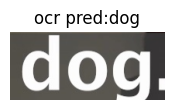

Loaded as API: https://mountchicken-maerec-gradio.hf.space/ ✔


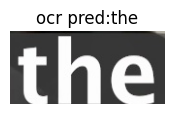

Loaded as API: https://mountchicken-maerec-gradio.hf.space/ ✔


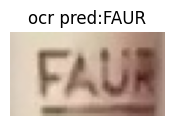

Loaded as API: https://mountchicken-maerec-gradio.hf.space/ ✔


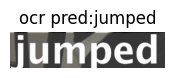

Loaded as API: https://mountchicken-maerec-gradio.hf.space/ ✔


WriteTimeout: The write operation timed out

In [144]:
from gradio_client import Client
import matplotlib.pyplot as plt

def ocr(image):
    '''
    param image should be path to the image '''
    
    client = Client("https://mountchicken-maerec-gradio.hf.space/")
    result = client.predict(image,False, fn_index=1)

    # get just the predicted word
    pred = result[1] # this is just a string like 'pred: jumped score: 1.00' so we need to parse it to get just the word
    start_index = pred.find('pred:') + len('pred:')
    end_index = pred.find('score:')
    
    return pred[start_index:end_index].strip()


### do ocr on all of the processed images of individual words in my directory 'out_frame150'

directory = 'out_frame150'
files = os.listdir(directory)

for img in files:
    if img.endswith('.jpg'):
        file_path = os.path.join(directory, img)
        image = Image.open(file_path)

        result = ocr(file_path)
        plt.figure(figsize=(2, 2))
        plt.axis('off')
        plt.imshow(image)
        plt.title(f"ocr pred:{result}")
        plt.show()